In [34]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
# from natsort import natsorted
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
# import shap
from sklearn.preprocessing import LabelEncoder
from scipy.spatial.transform import Rotation as R
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from scipy.signal import correlate
from sklearn.ensemble import ExtraTreesClassifier
from scipy.stats import entropy
from scipy.stats import kurtosis, skew
from scipy.fft import fft, fftfreq
from scipy.stats import iqr


In [36]:
# a()

In [37]:
# def zero_crossing_rate(signal):
#     """Tính số lần tín hiệu cắt qua 0"""
#     return np.sum(np.diff(np.sign(signal)) != 0)

# def calculate_elbow_angle_quat(window, upper_sensor, wrist_sensor):
#     """Tính góc khuỷu tay cho từng cửa sổ sử dụng quaternion"""
#     upper_quat = window[[f'{upper_sensor}/quat_x', f'{upper_sensor}/quat_y',
#                          f'{upper_sensor}/quat_z', f'{upper_sensor}/quat_w']].values
#     wrist_quat = window[[f'{wrist_sensor}/quat_x', f'{wrist_sensor}/quat_y',
#                          f'{wrist_sensor}/quat_z', f'{wrist_sensor}/quat_w']].values

#     vec_upper = R.from_quat(upper_quat).apply([0, 0, 1])
#     vec_wrist = R.from_quat(wrist_quat).apply([0, 0, 1])

#     dot = np.einsum('ij,ij->i', vec_upper, vec_wrist)
#     norm = np.linalg.norm(vec_upper, axis=1) * np.linalg.norm(vec_wrist, axis=1) + 1e-8
#     return np.degrees(np.arccos(np.clip(dot/norm, -1, 1))).mean()

# def window_feature_extraction(window):
#     """Trích xuất tất cả các đặc trưng cho từng cửa sổ"""
#     features = {}
#     sensors = ['atr01', 'atr02', 'atr03', 'atr04']

#     # Các trục dữ liệu cần tính toán cho cả gia tốc và con quay hồi chuyển
#     signal_axes = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

#     for s in sensors:
#         # Tính độ lớn (magnitude) cho acc và gyro
#         acc_mag = np.sqrt(window[f'{s}/acc_x']**2 +
#                           window[f'{s}/acc_y']**2 +
#                           window[f'{s}/acc_z']**2)
#         gyro_mag = np.sqrt(window[f'{s}/gyro_x']**2 +
#                            window[f'{s}/gyro_y']**2 +
#                            window[f'{s}/gyro_z']**2)

#         # Lưu lại giá trị trung bình của độ lớn
#         features[f'{s}/acc_mag_avg'] = acc_mag.mean()
#         features[f'{s}/gyro_mag_avg'] = gyro_mag.mean()
#         # Các tính chất động học bổ sung
#         features[f'{s}/jerk'] = acc_mag.diff().mean() * 30

#         # Duyệt qua từng trục của sensor
#         for ax in signal_axes:
#             signal = window[f'{s}/{ax}'].values

#             features[f'{s}/{ax}_mean'] = window[f'{s}/{ax}'].mean()
#             features[f'{s}/{ax}_std'] = window[f'{s}/{ax}'].std()
#             features[f'{s}/{ax}_median'] = window[f'{s}/{ax}'].median()
#             features[f'{s}/{ax}_kurtosis'] = kurtosis(signal)
#             features[f'{s}/{ax}_skewness'] = skew(signal)
#             features[f'{s}/{ax}_zcr'] = zero_crossing_rate(signal)

#         # Tính các đặc trưng cho magnitude
#         # Chúng ta tính median, kurtosis, skewness, và zcr cho acc_mag và gyro_mag
#         for mag, label in zip([acc_mag, gyro_mag], ['acc_mag', 'gyro_mag']):
#             features[f'{s}/{label}_median'] = np.median(mag)
#             features[f'{s}/{label}_kurtosis'] = kurtosis(mag)
#             features[f'{s}/{label}_skewness'] = skew(mag)
#             # features[f'{s}/{label}_zcr'] = zero_crossing_rate(mag) ############################################

#     # 2. Góc khuỷu tay
#     features.update({
#         'elbow_angle_right': calculate_elbow_angle_quat(window, 'atr03', 'atr01'),
#         'elbow_angle_left': calculate_elbow_angle_quat(window, 'atr04', 'atr02')
#     })

#     # 3. Độ trễ tương quan chéo
#     def _calc_lag(s1, s2, axis='acc_z'):
#         x = window[f'{s1}/{axis}'].values
#         y = window[f'{s2}/{axis}'].values
#         if len(x) < 10 or len(y) < 10:
#             return 0
#         corr = correlate(x - x.mean(), y - y.mean(), mode='valid')
#         return np.argmax(corr) - len(y) + 1

#     features.update({
#         'lag_right_arm': _calc_lag('atr03', 'atr01'),
#         'lag_left_arm': _calc_lag('atr04', 'atr02')
#     })

#     # 4. Đặc trưng tần số và entropy
#     for s in sensors:
#         sig = window[f'{s}/acc_x'].values
#         if len(sig) > 10:
#             fft_vals = np.abs(fft(sig))
#             features[f'{s}/dominant_freq'] = np.argmax(fft_vals[:len(fft_vals)//2])
#         else:
#             features[f'{s}/dominant_freq'] = 0

#     # 5. Đặc trưng động học nâng cao
#     for s in ['atr01', 'atr02']:
#         roll = window[f'{s}/roll'].values
#         features[f'{s}/wrist_stability'] = roll.std() if len(roll) > 1 else 0

#     # 6. Đặc trưng rolling
#     window_cp = window.copy()
#     for i in [1, 2]:
#         sensor = f'atr0{i}'
#         window_cp[f'{sensor}/wrist_stability'] = window_cp[f'{sensor}/roll'].rolling(window=10, min_periods=1).std().values
#         window_cp[f'{sensor}/stillness'] = (window_cp[f'{sensor}/gyro_mag'] < 5).rolling(window=15, min_periods=1).sum().values

#     # Lấy giá trị cuối cùng của các đặc trưng rolling
#     last_row = window_cp.iloc[-1]
#     for col in window_cp.columns:
#         if 'stability' in col or 'stillness' in col:
#             features[col] = last_row[col]

#     return features


# def process_pipeline(data_path, window_size=30, step_size=15):
#     """Pipeline xử lý hoàn chỉnh"""
#     df = pd.read_csv(data_path)
#     df = df.drop(['Unnamed: 0', 'action'], axis = 1)
#     df.ffill(inplace=True)
#     df.bfill(inplace=True)

#     # Tiền xử lý cơ bản
#     for i in range(1, 5):
#         df[f'atr0{i}/acc_mag'] = np.sqrt(df[f'atr0{i}/acc_x']**2 +
#                                         df[f'atr0{i}/acc_y']**2 +
#                                         df[f'atr0{i}/acc_z']**2)
#         df[f'atr0{i}/gyro_mag'] = np.sqrt(df[f'atr0{i}/gyro_x']**2 +
#                                          df[f'atr0{i}/gyro_y']**2 +
#                                          df[f'atr0{i}/gyro_z']**2)

#     features = []
#     labels = []

#     for start in range(0, len(df) - window_size + 1, step_size):
#         window = df.iloc[start:start+window_size].copy()

#         # Tính toán các đặc trưng động trong cửa sổ
#         window = calculate_window_features(window)
#         feats = window_feature_extraction(window)

#         features.append(feats)
#         labels.append(window['operation'].mode()[0])

#     return pd.DataFrame(features).assign(operation=labels)

# def calculate_window_features(window):
#     """Tính toán các đặc trưng phụ thuộc thời gian trong cửa sổ"""
#     # Tính toán Euler angles
#     for i in [1, 2]:
#         quat = window[[f'atr0{i}/quat_x', f'atr0{i}/quat_y',
#                      f'atr0{i}/quat_z', f'atr0{i}/quat_w']].values
#         euler = R.from_quat(quat).as_euler('xyz', degrees=True)
#         window[f'atr0{i}/roll'] = euler[:, 0]
#         window[f'atr0{i}/pitch'] = euler[:, 1]
#         window[f'atr0{i}/yaw'] = euler[:, 2]

#     # Các tính toán khác
#     window['acc_mag_diff_01_02'] = window['atr01/acc_mag'] - window['atr02/acc_mag']
#     window['pseudo_torque_right'] = (window['atr03/gyro_mag'] - window['atr01/gyro_mag']) * (window['atr03/acc_mag'] + window['atr01/acc_mag']) * 0.3

#     return window

In [38]:
# def calculate_window_features(window):
#     """Tính toán các đặc trưng phụ thuộc thời gian trong cửa sổ"""
#     # Tính toán Euler angles
#     for i in [1, 2]:
#         quat = window[[f'atr0{i}/quat_x', f'atr0{i}/quat_y',
#                      f'atr0{i}/quat_z', f'atr0{i}/quat_w']].values
#         euler = R.from_quat(quat).as_euler('xyz', degrees=True)
#         window[f'atr0{i}/roll'] = euler[:, 0]
#         window[f'atr0{i}/pitch'] = euler[:, 1]
#         window[f'atr0{i}/yaw'] = euler[:, 2]

#     # Các tính toán khác
#     window['acc_mag_diff_01_02'] = window['atr01/acc_mag'] - window['atr02/acc_mag']
#     window['pseudo_torque_right'] = (window['atr03/gyro_mag'] - window['atr01/gyro_mag']) * (window['atr03/acc_mag'] + window['atr01/acc_mag']) * 0.3

#     return window

# def zero_crossing_rate(signal):
#     """Tính số lần tín hiệu cắt qua 0"""
#     return np.sum(np.diff(np.sign(signal)) != 0)


# def calculate_elbow_angle_quat(window, upper_sensor, wrist_sensor):
#     """Tính góc khuỷu tay cho từng cửa sổ sử dụng quaternion"""
#     upper_quat = window[[f'{upper_sensor}/quat_x', f'{upper_sensor}/quat_y',
#                          f'{upper_sensor}/quat_z', f'{upper_sensor}/quat_w']].values
#     wrist_quat = window[[f'{wrist_sensor}/quat_x', f'{wrist_sensor}/quat_y',
#                          f'{wrist_sensor}/quat_z', f'{wrist_sensor}/quat_w']].values

#     vec_upper = R.from_quat(upper_quat).apply([0, 0, 1])
#     vec_wrist = R.from_quat(wrist_quat).apply([0, 0, 1])

#     dot = np.einsum('ij,ij->i', vec_upper, vec_wrist)
#     norm = np.linalg.norm(vec_upper, axis=1) * np.linalg.norm(vec_wrist, axis=1) + 1e-8
#     return np.degrees(np.arccos(np.clip(dot/norm, -1, 1))).mean()


# def window_feature_extraction_v3(window, sampling_rate=30):
#     """Trích xuất đặc trưng cho từng cửa sổ, bổ sung RMS và range để đưa lên ~250 features"""
#     features = {}
#     sensors = ['atr01', 'atr02', 'atr03', 'atr04']
#     signal_axes = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

#     for s in sensors:
#         acc_mag = np.sqrt(window[f'{s}/acc_x']**2 +
#                           window[f'{s}/acc_y']**2 +
#                           window[f'{s}/acc_z']**2)
#         gyro_mag = np.sqrt(window[f'{s}/gyro_x']**2 +
#                            window[f'{s}/gyro_y']**2 +
#                            window[f'{s}/gyro_z']**2)

#         features[f'{s}/acc_mag_mean'] = acc_mag.mean()
#         features[f'{s}/gyro_mag_mean'] = gyro_mag.mean()
#         features[f'{s}/jerk'] = acc_mag.diff().mean() * sampling_rate

#         for ax in signal_axes:
#             sig = window[f'{s}/{ax}'].values
#             features[f'{s}/{ax}_mean'] = np.mean(sig)
#             features[f'{s}/{ax}_std'] = np.std(sig)
#             features[f'{s}/{ax}_median'] = np.median(sig)
#             features[f'{s}/{ax}_kurtosis'] = kurtosis(sig)
#             features[f'{s}/{ax}_skewness'] = skew(sig)
#             features[f'{s}/{ax}_zcr'] = zero_crossing_rate(sig)
#             # Bổ sung RMS và range
#             features[f'{s}/{ax}_rms'] = np.sqrt(np.mean(sig**2))
#             features[f'{s}/{ax}_range'] = np.max(sig) - np.min(sig)

#         # magnitude details (no zcr for magnitude features)
#         for mag, label in zip([acc_mag, gyro_mag], ['acc_mag', 'gyro_mag']):
#             features[f'{s}/{label}_median'] = np.median(mag)
#             features[f'{s}/{label}_kurtosis'] = kurtosis(mag)
#             features[f'{s}/{label}_skewness'] = skew(mag)

#     # elbow angles
#     features['elbow_angle_right'] = calculate_elbow_angle_quat(window, 'atr03', 'atr01')
#     features['elbow_angle_left']  = calculate_elbow_angle_quat(window, 'atr04', 'atr02')

#     # lag
#     def _calc_lag(s1, s2, axis='acc_z'):
#         x = window[f'{s1}/{axis}'].values
#         y = window[f'{s2}/{axis}'].values
#         if len(x) < 10: return 0
#         corr = correlate(x - x.mean(), y - y.mean(), mode='valid')
#         return np.argmax(corr) - len(y) + 1

#     features['lag_right_arm'] = _calc_lag('atr03', 'atr01')
#     features['lag_left_arm']  = _calc_lag('atr04', 'atr02')

#     # dominant freq
#     for s in sensors:
#         sig = window[f'{s}/acc_x'].values
#         if len(sig) > 10:
#             fft_vals = np.abs(fft(sig))
#             features[f'{s}/dominant_freq'] = np.argmax(fft_vals[:len(fft_vals)//2])
#         else:
#             features[f'{s}/dominant_freq'] = 0

#     # wrist stability
#     for s in ['atr01', 'atr02']:
#         roll = window[f'{s}/roll'].values
#         features[f'{s}/wrist_stability'] = roll.std() if len(roll) > 1 else 0

#     # rolling features
#     window_cp = window.copy()
#     for i in [1, 2]:
#         sensor = f'atr0{i}'
#         window_cp[f'{sensor}/wrist_stability'] = window_cp[f'{sensor}/roll'].rolling(window=10, min_periods=1).std()
#         window_cp[f'{sensor}/stillness'] = (window_cp[f'{sensor}/gyro_mag'] < 5).rolling(window=15, min_periods=1).sum()
#     last = window_cp.iloc[-1]
#     for col in window_cp.columns:
#         if 'stability' in col or 'stillness' in col:
#             features[col] = last[col]

#     return features


# def process_pipeline(data_path, window_size=30, step_size=15):
#     df = pd.read_csv(data_path)
#     df = df.drop(['Unnamed: 0', 'action'], axis=1)
#     df.ffill(inplace=True)
#     df.bfill(inplace=True)

#     # Tính toán độ lớn (magnitude) cho accelerometer và gyroscope
#     for i in range(1, 5):
#         df[f'atr0{i}/acc_mag'] = np.sqrt(
#             df[f'atr0{i}/acc_x']**2 + df[f'atr0{i}/acc_y']**2 + df[f'atr0{i}/acc_z']**2
#         )
#         df[f'atr0{i}/gyro_mag'] = np.sqrt(
#             df[f'atr0{i}/gyro_x']**2 + df[f'atr0{i}/gyro_y']**2 + df[f'atr0{i}/gyro_z']**2
#         )

#     # Pre-compute quaternion (Euler angles) and other time dependent features.
#     df = calculate_window_features(df)

#     feats, labels = [], []
#     for start in range(0, len(df) - window_size + 1, step_size):
#         window = df.iloc[start:start + window_size].copy()
#         feats.append(window_feature_extraction_v3(window))
#         labels.append(window['operation'].mode()[0])

#     return pd.DataFrame(feats).assign(operation=labels)


In [39]:
# Danh sách các feature cần loại bỏ (tương quan cao)
DROPPED_FEATURES = {
    'atr01/acc_x_median', 'atr01/acc_x_range', 'atr01/acc_y_median', 'atr01/acc_y_range',
    'atr01/acc_z_median', 'atr01/gyro_x_rms', 'atr01/gyro_x_range', 'atr01/gyro_y_rms',
    'atr01/gyro_y_range', 'atr01/gyro_z_rms', 'atr01/gyro_z_range', 'atr01/gyro_mag_skewness',
    'atr02/acc_x_range', 'atr02/acc_y_median', 'atr02/acc_y_range', 'atr02/acc_z_median',
    'atr02/gyro_x_rms', 'atr02/gyro_x_range', 'atr02/gyro_y_rms', 'atr02/gyro_y_range',
    'atr02/gyro_z_rms', 'atr02/gyro_z_range', 'atr02/gyro_mag_median', 'atr02/gyro_mag_skewness',
    'atr03/acc_x_median', 'atr03/acc_x_rms', 'atr03/acc_x_range', 'atr03/acc_y_mean',
    'atr03/acc_y_median', 'atr03/acc_y_rms', 'atr03/acc_y_range', 'atr03/acc_z_median',
    'atr03/acc_z_range', 'atr03/gyro_x_rms', 'atr03/gyro_x_range', 'atr03/gyro_y_std',
    'atr03/gyro_y_rms', 'atr03/gyro_y_range', 'atr03/gyro_z_rms', 'atr03/gyro_z_range',
    'atr03/gyro_mag_median', 'atr03/gyro_mag_skewness', 'atr04/acc_x_median',
    'atr04/acc_x_rms', 'atr04/acc_x_range', 'atr04/acc_y_mean', 'atr04/acc_y_median',
    'atr04/acc_y_rms', 'atr04/acc_y_range', 'atr04/acc_z_median', 'atr04/gyro_x_rms',
    'atr04/gyro_x_range', 'atr04/gyro_y_std', 'atr04/gyro_y_rms', 'atr04/gyro_y_range',
    'atr04/gyro_z_rms', 'atr04/gyro_z_range', 'atr04/gyro_mag_median',
    'atr04/gyro_mag_skewness'
}

def zero_crossing_rate(signal):
    """Tính số lần tín hiệu cắt qua 0"""
    return np.sum(np.diff(np.sign(signal)) != 0)


def calculate_elbow_angle_quat(window, upper_sensor, wrist_sensor):
    """Tính góc khuỷu tay cho từng cửa sổ sử dụng quaternion"""
    upper_quat = window[[f'{upper_sensor}/quat_x', f'{upper_sensor}/quat_y',
                         f'{upper_sensor}/quat_z', f'{upper_sensor}/quat_w']].values
    wrist_quat = window[[f'{wrist_sensor}/quat_x', f'{wrist_sensor}/quat_y',
                         f'{wrist_sensor}/quat_z', f'{wrist_sensor}/quat_w']].values

    vec_upper = R.from_quat(upper_quat).apply([0, 0, 1])
    vec_wrist = R.from_quat(wrist_quat).apply([0, 0, 1])

    dot = np.einsum('ij,ij->i', vec_upper, vec_wrist)
    norm = np.linalg.norm(vec_upper, axis=1) * np.linalg.norm(vec_wrist, axis=1) + 1e-8
    return np.degrees(np.arccos(np.clip(dot/norm, -1, 1))).mean()


def window_feature_extraction_v3(window, sampling_rate=30):
    """Trích xuất đặc trưng cho từng cửa sổ, bỏ các feature tương quan cao"""
    features = {}
    sensors = ['atr01', 'atr02', 'atr03', 'atr04']
    signal_axes = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

    # Tính toán thống kê cơ bản và đặc trưng mở rộng
    for s in sensors:
        acc_mag = np.sqrt(window[f'{s}/acc_x']**2 +
                          window[f'{s}/acc_y']**2 +
                          window[f'{s}/acc_z']**2)
        gyro_mag = np.sqrt(window[f'{s}/gyro_x']**2 +
                           window[f'{s}/gyro_y']**2 +
                           window[f'{s}/gyro_z']**2)

        features[f'{s}/acc_mag_mean'] = acc_mag.mean()
        features[f'{s}/gyro_mag_mean'] = gyro_mag.mean()
        features[f'{s}/jerk'] = acc_mag.diff().mean() * sampling_rate

        for ax in signal_axes:
            sig = window[f'{s}/{ax}'].values
            features[f'{s}/{ax}_mean'] = np.mean(sig)
            features[f'{s}/{ax}_std'] = np.std(sig)
            features[f'{s}/{ax}_median'] = np.median(sig)
            features[f'{s}/{ax}_kurtosis'] = kurtosis(sig)
            features[f'{s}/{ax}_skewness'] = skew(sig)
            features[f'{s}/{ax}_zcr'] = zero_crossing_rate(sig)
            features[f'{s}/{ax}_rms'] = np.sqrt(np.mean(sig**2))
            features[f'{s}/{ax}_range'] = np.max(sig) - np.min(sig)

        for mag, label in zip([acc_mag, gyro_mag], ['acc_mag', 'gyro_mag']):
            features[f'{s}/{label}_median'] = np.median(mag)
            features[f'{s}/{label}_kurtosis'] = kurtosis(mag)
            features[f'{s}/{label}_skewness'] = skew(mag)

    # Góc khuỷu tay
    features['elbow_angle_right'] = calculate_elbow_angle_quat(window, 'atr03', 'atr01')
    features['elbow_angle_left']  = calculate_elbow_angle_quat(window, 'atr04', 'atr02')

    # Lag giữa hai sensor
    def _calc_lag(s1, s2, axis='acc_z'):
        x = window[f'{s1}/{axis}'].values
        y = window[f'{s2}/{axis}'].values
        if len(x) < 10: return 0
        corr = correlate(x - x.mean(), y - y.mean(), mode='valid')
        return np.argmax(corr) - len(y) + 1

    features['lag_right_arm'] = _calc_lag('atr03', 'atr01')
    features['lag_left_arm']  = _calc_lag('atr04', 'atr02')

    # Tần số chi phối
    for s in sensors:
        sig = window[f'{s}/acc_x'].values
        if len(sig) > 10:
            fft_vals = np.abs(fft(sig))
            features[f'{s}/dominant_freq'] = np.argmax(fft_vals[:len(fft_vals)//2])
        else:
            features[f'{s}/dominant_freq'] = 0

    # Độ ổn định cổ tay
    for s in ['atr01', 'atr02']:
        roll = window[f'{s}/roll'].values
        features[f'{s}/wrist_stability'] = roll.std() if len(roll) > 1 else 0

    # Rolling features
    window_cp = window.copy()
    for i in [1, 2]:
        sensor = f'atr0{i}'
        window_cp[f'{sensor}/wrist_stability'] = window_cp[f'{sensor}/roll'].rolling(window=10, min_periods=1).std()
        window_cp[f'{sensor}/stillness'] = (window_cp[f'{sensor}/gyro_mag'] < 5).rolling(window=15, min_periods=1).sum()
    last = window_cp.iloc[-1]
    for col in window_cp.columns:
        if 'stability' in col or 'stillness' in col:
            features[col] = last[col]

    # Loại bỏ các feature tương quan cao
    for key in list(DROPPED_FEATURES):
        features.pop(key, None)

    return features


def calculate_window_features(window):
    """Tính toán các đặc trưng phụ thuộc thời gian trong cửa sổ"""
    for i in [1, 2]:
        quat = window[[f'atr0{i}/quat_x', f'atr0{i}/quat_y',
                     f'atr0{i}/quat_z', f'atr0{i}/quat_w']].values
        euler = R.from_quat(quat).as_euler('xyz', degrees=True)
        window[f'atr0{i}/roll'] = euler[:, 0]
        window[f'atr0{i}/pitch'] = euler[:, 1]
        window[f'atr0{i}/yaw'] = euler[:, 2]

    window['acc_mag_diff_01_02'] = window['atr01/acc_mag'] - window['atr02/acc_mag']
    window['pseudo_torque_right'] = (
        (window['atr03/gyro_mag'] - window['atr01/gyro_mag']) *
        (window['atr03/acc_mag'] + window['atr01/acc_mag']) * 0.3
    )
    return window


def process_pipeline(data_path, window_size=30, step_size=15):
    df = pd.read_csv(data_path)
    df = df.drop(['Unnamed: 0', 'action'], axis=1)
    df.ffill(inplace=True)
    df.bfill(inplace=True)

    for i in range(1, 5):
        df[f'atr0{i}/acc_mag'] = np.sqrt(
            df[f'atr0{i}/acc_x']**2 + df[f'atr0{i}/acc_y']**2 + df[f'atr0{i}/acc_z']**2
        )
        df[f'atr0{i}/gyro_mag'] = np.sqrt(
            df[f'atr0{i}/gyro_x']**2 + df[f'atr0{i}/gyro_y']**2 + df[f'atr0{i}/gyro_z']**2
        )
    df = calculate_window_features(df)

    feats, labels = [], []
    for start in range(0, len(df) - window_size + 1, step_size):
        window = df.iloc[start:start + window_size].copy()
        feats.append(window_feature_extraction_v3(window))
        labels.append(window['operation'].mode()[0])

    return pd.DataFrame(feats).assign(operation=labels)


In [ ]:
# import numpy as np
# import pandas as pd
# from scipy.signal import correlate
# from scipy.stats import skew, kurtosis
# from scipy.fft import fft
# from scipy.spatial.transform import Rotation as R

# def zero_crossing_rate(signal):
#     return np.sum(np.diff(np.sign(signal)) != 0

# def calculate_elbow_angle_quat(window, upper_sensor, wrist_sensor):
#     upper_quat = window[[f'{upper_sensor}/quat_x', f'{upper_sensor}/quat_y',
#                          f'{upper_sensor}/quat_z', f'{upper_sensor}/quat_w']].values
#     wrist_quat = window[[f'{wrist_sensor}/quat_x', f'{wrist_sensor}/quat_y',
#                          f'{wrist_sensor}/quat_z', f'{wrist_sensor}/quat_w']].values

#     # Normalize quaternions
#     upper_quat = upper_quat / np.linalg.norm(upper_quat, axis=1, keepdims=True)
#     wrist_quat = wrist_quat / np.linalg.norm(wrist_quat, axis=1, keepdims=True)

#     vec_upper = R.from_quat(upper_quat).apply([0, 0, 1])
#     vec_wrist = R.from_quat(wrist_quat).apply([0, 0, 1])

#     dot = np.einsum('ij,ij->i', vec_upper, vec_wrist)
#     norm = np.linalg.norm(vec_upper, axis=1) * np.linalg.norm(vec_wrist, axis=1) + 1e-8
#     return np.degrees(np.arccos(np.clip(dot/norm, -1, 1))).mean()

# def window_feature_extraction(window, sampling_rate=30):
#     features = {}
#     sensors = ['atr01', 'atr02', 'atr03', 'atr04']

#     for s in sensors:
#         # Sử dụng magnitude đã tính từ trước
#         acc_mag = window[f'{s}/acc_mag']
#         gyro_mag = window[f'{s}/gyro_mag']

#         features[f'{s}/acc_mag_avg'] = acc_mag.mean()
#         features[f'{s}/gyro_mag_avg'] = gyro_mag.mean()
#         features[f'{s}/jerk'] = acc_mag.diff().mean() * sampling_rate  # Sử dụng sampling_rate

#         for ax in ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']:
#             signal = window[f'{s}/{ax}'].values
#             features[f'{s}/{ax}_mean'] = signal.mean()
#             features[f'{s}/{ax}_std'] = signal.std()
#             features[f'{s}/{ax}_median'] = np.median(signal)
#             features[f'{s}/{ax}_kurtosis'] = kurtosis(signal)
#             features[f'{s}/{ax}_skewness'] = skew(signal)
#             features[f'{s}/{ax}_zcr'] = zero_crossing_rate(signal)

#         # Tính toán các đặc trưng cho magnitude
#         for mag, label in zip([acc_mag, gyro_mag], ['acc_mag', 'gyro_mag']):
#             features[f'{s}/{label}_median'] = np.median(mag)
#             features[f'{s}/{label}_kurtosis'] = kurtosis(mag)
#             features[f'{s}/{label}_skewness'] = skew(mag)
#             features[f'{s}/{label}_zcr'] = zero_crossing_rate(mag.values)  # Bỏ comment

#     # Các phần còn lại giữ nguyên với các sửa đổi đã đề cập
#     # ...
#     return features

# def process_pipeline(data_path, window_size=30, step_size=15, sampling_rate=30):
#     df = pd.read_csv(data_path)
#     cols_to_drop = ['Unnamed: 0', 'action']
#     existing_cols = [col for col in cols_to_drop if col in df.columns]
#     df = df.drop(existing_cols, axis=1)
#     df.ffill(inplace=True)
#     df.bfill(inplace=True)

#     for i in range(1, 5):
#         df[f'atr0{i}/acc_mag'] = np.sqrt(df[f'atr0{i}/acc_x']**2 +
#                                       df[f'atr0{i}/acc_y']**2 +
#                                       df[f'atr0{i}/acc_z']**2)
#         df[f'atr0{i}/gyro_mag'] = np.sqrt(df[f'atr0{i}/gyro_x']**2 +
#                                        df[f'atr0{i}/gyro_y']**2 +
#                                        df[f'atr0{i}/gyro_z']**2)

#     features = []
#     labels = []

#     for start in range(0, len(df) - window_size + 1, step_size):
#         window = df.iloc[start:start+window_size].copy()
#         window = calculate_window_features(window)
#         feats = window_feature_extraction(window, sampling_rate)
#         features.append(feats)
#         labels.append(window['operation'].mode()[0])

#     return pd.DataFrame(features).assign(operation=labels)

# # Các hàm còn lại giữ nguyên với điều chỉnh tương tự

In [40]:
gendata =  ['/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_1.csv', '/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_2.csv', '/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_3.csv', '/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_4.csv', '/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_5.csv', '/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_6.csv', '/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_7.csv', '/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_8.csv', '/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_9.csv', '/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_10.csv', '/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_11.csv', '/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_12.csv', '/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_13.csv']

In [41]:
data_train_file_1       = process_pipeline('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_1.csv')
data_train_file_4       = process_pipeline('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_4.csv')
data_train_file_5       = process_pipeline('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_5.csv')
data_train_file_6       = process_pipeline('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_6.csv')
data_train_file_7       = process_pipeline('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_7.csv')
data_train_file_8       = process_pipeline('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_8.csv')
data_train_file_9       = process_pipeline('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_9.csv')
data_train_file_10      = process_pipeline('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_10.csv')
data_train_file_11      = process_pipeline('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_11.csv')
data_train_file_12      = process_pipeline('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_12.csv')
data_train_file_13      = process_pipeline('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_13.csv')




data_test_file_2        = process_pipeline('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_2.csv')
data_test_file_3        = process_pipeline('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_3.csv')



In [42]:
# def drop_highly_correlated(
#     X_df: pd.DataFrame,
#     corr_thresh: float = 0.9) -> (pd.DataFrame, list):
#     """
#     Loại bỏ các feature có tương quan tuyệt đối vượt ngưỡng corr_thresh.

#     Args:
#       X_df: DataFrame chỉ chứa feature (kiểu số).
#       corr_thresh: ngưỡng tương quan (mặc định 0.9).

#     Returns:
#       X_reduced_df: DataFrame sau khi drop.
#       dropped: list tên các feature đã loại.
#     """
#     # Tính ma trận tương quan tuyệt đối
#     corr = X_df.corr().abs()
#     # Lấy tam giác trên (không tính đường chéo)
#     upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
#     # Danh sách các cột có corr > threshold với bất kỳ cột nào khác
#     dropped = [col for col in upper.columns if any(upper[col] > corr_thresh)]
#     # Drop
#     X_reduced_df = X_df.drop(columns=dropped)
#     return X_reduced_df, dropped



In [43]:
# X_reduced_df, dropped = drop_highly_correlated(data_train_file_1, corr_thresh=0.9)
# print(f"Dropped {len(dropped)} features:", dropped)
# print("Shape before:", data_train_file_1.shape, "after:", X_reduced_df.shape)

# Dropped 59 features: ['atr01/acc_x_median', 'atr01/acc_x_range', 'atr01/acc_y_median', 'atr01/acc_y_range', 'atr01/acc_z_median', 'atr01/gyro_x_rms', 'atr01/gyro_x_range', 'atr01/gyro_y_rms', 'atr01/gyro_y_range', 'atr01/gyro_z_rms', 'atr01/gyro_z_range', 'atr01/gyro_mag_skewness', 'atr02/acc_x_range', 'atr02/acc_y_median', 'atr02/acc_y_range', 'atr02/acc_z_median', 'atr02/gyro_x_rms', 'atr02/gyro_x_range', 'atr02/gyro_y_rms', 'atr02/gyro_y_range', 'atr02/gyro_z_rms', 'atr02/gyro_z_range', 'atr02/gyro_mag_median', 'atr02/gyro_mag_skewness', 'atr03/acc_x_median', 'atr03/acc_x_rms', 'atr03/acc_x_range', 'atr03/acc_y_mean', 'atr03/acc_y_median', 'atr03/acc_y_rms', 'atr03/acc_y_range', 'atr03/acc_z_median', 'atr03/acc_z_range', 'atr03/gyro_x_rms', 'atr03/gyro_x_range', 'atr03/gyro_y_std', 'atr03/gyro_y_rms', 'atr03/gyro_y_range', 'atr03/gyro_z_rms', 'atr03/gyro_z_range', 'atr03/gyro_mag_median', 'atr03/gyro_mag_skewness', 'atr04/acc_x_median', 'atr04/acc_x_rms', 'atr04/acc_x_range', 'atr04/acc_y_mean', 'atr04/acc_y_median', 'atr04/acc_y_rms', 'atr04/acc_y_range', 'atr04/acc_z_median', 'atr04/gyro_x_rms', 'atr04/gyro_x_range', 'atr04/gyro_y_std', 'atr04/gyro_y_rms', 'atr04/gyro_y_range', 'atr04/gyro_z_rms', 'atr04/gyro_z_range', 'atr04/gyro_mag_median', 'atr04/gyro_mag_skewness']
# Shape before: (4972, 241) after: (4972, 182)

In [44]:
train_dfs = [
    data_train_file_1,
    data_train_file_4,
    data_train_file_5,
    data_train_file_6,
    data_train_file_7,
    data_train_file_8,
    data_train_file_9,
    data_train_file_10,
    data_train_file_11,
    data_train_file_12,
    data_train_file_13
]

data_train = pd.concat(train_dfs, ignore_index=True)



In [45]:
data_test = pd.concat([data_test_file_2, data_test_file_3], ignore_index=True)

In [46]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50419 entries, 0 to 50418
Columns: 182 entries, atr01/acc_mag_mean to operation
dtypes: float64(151), int64(31)
memory usage: 70.0 MB


In [47]:
data_train.head()

,atr01/acc_mag_mean,atr01/gyro_mag_mean,atr01/jerk,atr01/acc_x_mean,atr01/acc_x_std,atr01/acc_x_kurtosis,atr01/acc_x_skewness,atr01/acc_x_zcr,atr01/acc_x_rms,atr01/acc_y_mean,...,lag_left_arm,atr01/dominant_freq,atr02/dominant_freq,atr03/dominant_freq,atr04/dominant_freq,atr01/wrist_stability,atr02/wrist_stability,atr01/stillness,atr02/stillness,operation
0,1.065149,130.811351,-0.066157,0.714973,0.429831,0.316952,-0.746589,5,0.834231,0.343197,...,-29,0,0,0,0,43.247316,64.058235,1.0,0.0,100
1,1.039036,85.258319,0.308363,0.799407,0.338684,2.804956,-1.678826,2,0.868192,0.266177,...,-29,0,0,0,0,54.657517,97.460434,0.0,0.0,100
2,1.020553,74.544164,-0.119560,0.785223,0.245917,-0.573943,-0.556469,0,0.822831,0.336157,...,-29,0,0,0,0,36.375185,30.361599,0.0,0.0,100
3,1.041770,71.657631,-0.284668,0.670063,0.276917,0.746557,-0.802753,2,0.725030,0.424843,...,-29,0,0,0,0,21.723514,51.943404,0.0,0.0,100
4,1.036813,84.055072,-0.502104,0.614697,0.343025,0.529429,-0.877190,3,0.703931,0.382937,...,-29,0,0,0,0,36.806538,44.527458,0.0,0.0,100


In [48]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10389 entries, 0 to 10388
Columns: 182 entries, atr01/acc_mag_mean to operation
dtypes: float64(151), int64(31)
memory usage: 14.4 MB


In [49]:
data_test.head()

,atr01/acc_mag_mean,atr01/gyro_mag_mean,atr01/jerk,atr01/acc_x_mean,atr01/acc_x_std,atr01/acc_x_kurtosis,atr01/acc_x_skewness,atr01/acc_x_zcr,atr01/acc_x_rms,atr01/acc_y_mean,...,lag_left_arm,atr01/dominant_freq,atr02/dominant_freq,atr03/dominant_freq,atr04/dominant_freq,atr01/wrist_stability,atr02/wrist_stability,atr01/stillness,atr02/stillness,operation
0,1.010330,89.735286,0.332754,0.852390,0.199539,1.331071,0.413116,0,0.875434,0.178960,...,-29,0,0,0,0,106.427056,79.486141,1.0,2.0,100
1,1.008487,90.489615,0.104220,0.838523,0.224720,0.570223,0.131509,0,0.868113,0.123053,...,-29,0,0,0,0,53.304272,45.729032,0.0,0.0,100
2,1.056498,93.335638,1.009548,0.823807,0.320304,4.864784,-1.482085,2,0.883885,0.263920,...,-29,0,0,0,0,73.210318,67.608244,0.0,0.0,100
3,1.082752,76.618785,0.084858,0.846850,0.322289,5.100365,-1.496120,2,0.906104,0.232457,...,-29,0,0,0,0,103.159763,28.125674,0.0,0.0,100
4,1.040547,84.184118,0.301821,0.857093,0.221194,-0.582077,-0.179243,0,0.885176,0.171943,...,-29,0,0,0,0,51.791312,50.494521,0.0,0.0,100


In [50]:
# c()

In [51]:
# data_train = data_train.drop(['Unnamed: 0', 'action'], axis = 1)
data_train['operation'] = data_train['operation'].astype('category')

# data_test_file_2 = data_test_file_2.drop(['Unnamed: 0', 'action'], axis = 1)
data_test['operation'] = data_test['operation'].astype('category')



In [52]:
print(f"▶️ data_train shape: {data_train.shape}")
print(f"▶️ data_train shape: {data_test.shape}")

▶️ data_train shape: (50419, 182)
▶️ data_train shape: (10389, 182)


In [53]:
data_train.columns

Index(['atr01/acc_mag_mean', 'atr01/gyro_mag_mean', 'atr01/jerk',
       'atr01/acc_x_mean', 'atr01/acc_x_std', 'atr01/acc_x_kurtosis',
       'atr01/acc_x_skewness', 'atr01/acc_x_zcr', 'atr01/acc_x_rms',
       'atr01/acc_y_mean',
       ...
       'lag_left_arm', 'atr01/dominant_freq', 'atr02/dominant_freq',
       'atr03/dominant_freq', 'atr04/dominant_freq', 'atr01/wrist_stability',
       'atr02/wrist_stability', 'atr01/stillness', 'atr02/stillness',
       'operation'],
      dtype='object', length=182)

In [54]:
# data_train = sliding_window_stats_acc_gyro(sliding_window_stats_acc_gyro)


In [55]:
def fill_nan(df):
  cols_to_fill = [col for col in df.columns if col != 'operation']
  df[cols_to_fill] = df[cols_to_fill].fillna(method='ffill')
  df[cols_to_fill] = df[cols_to_fill].fillna(method='bfill')

In [56]:
data_train.columns

Index(['atr01/acc_mag_mean', 'atr01/gyro_mag_mean', 'atr01/jerk',
       'atr01/acc_x_mean', 'atr01/acc_x_std', 'atr01/acc_x_kurtosis',
       'atr01/acc_x_skewness', 'atr01/acc_x_zcr', 'atr01/acc_x_rms',
       'atr01/acc_y_mean',
       ...
       'lag_left_arm', 'atr01/dominant_freq', 'atr02/dominant_freq',
       'atr03/dominant_freq', 'atr04/dominant_freq', 'atr01/wrist_stability',
       'atr02/wrist_stability', 'atr01/stillness', 'atr02/stillness',
       'operation'],
      dtype='object', length=182)

In [57]:
data_test_file_2.columns

Index(['atr01/acc_mag_mean', 'atr01/gyro_mag_mean', 'atr01/jerk',
       'atr01/acc_x_mean', 'atr01/acc_x_std', 'atr01/acc_x_kurtosis',
       'atr01/acc_x_skewness', 'atr01/acc_x_zcr', 'atr01/acc_x_rms',
       'atr01/acc_y_mean',
       ...
       'lag_left_arm', 'atr01/dominant_freq', 'atr02/dominant_freq',
       'atr03/dominant_freq', 'atr04/dominant_freq', 'atr01/wrist_stability',
       'atr02/wrist_stability', 'atr01/stillness', 'atr02/stillness',
       'operation'],
      dtype='object', length=182)

In [58]:
for i in data_train.columns:
  print(i)

atr01/acc_mag_mean
atr01/gyro_mag_mean
atr01/jerk
atr01/acc_x_mean
atr01/acc_x_std
atr01/acc_x_kurtosis
atr01/acc_x_skewness
atr01/acc_x_zcr
atr01/acc_x_rms
atr01/acc_y_mean
atr01/acc_y_std
atr01/acc_y_kurtosis
atr01/acc_y_skewness
atr01/acc_y_zcr
atr01/acc_y_rms
atr01/acc_z_mean
atr01/acc_z_std
atr01/acc_z_kurtosis
atr01/acc_z_skewness
atr01/acc_z_zcr
atr01/acc_z_rms
atr01/acc_z_range
atr01/gyro_x_mean
atr01/gyro_x_std
atr01/gyro_x_median
atr01/gyro_x_kurtosis
atr01/gyro_x_skewness
atr01/gyro_x_zcr
atr01/gyro_y_mean
atr01/gyro_y_std
atr01/gyro_y_median
atr01/gyro_y_kurtosis
atr01/gyro_y_skewness
atr01/gyro_y_zcr
atr01/gyro_z_mean
atr01/gyro_z_std
atr01/gyro_z_median
atr01/gyro_z_kurtosis
atr01/gyro_z_skewness
atr01/gyro_z_zcr
atr01/acc_mag_median
atr01/acc_mag_kurtosis
atr01/acc_mag_skewness
atr01/gyro_mag_median
atr01/gyro_mag_kurtosis
atr02/acc_mag_mean
atr02/gyro_mag_mean
atr02/jerk
atr02/acc_x_mean
atr02/acc_x_std
atr02/acc_x_median
atr02/acc_x_kurtosis
atr02/acc_x_skewness
atr02/

In [59]:
# a()

In [60]:

print("Kích thước dữ liệu train:", data_train.shape)
print("Kích thước dữ liệu test:", data_test.shape)

data_train.dropna(inplace=True)
data_test.dropna(inplace=True)


print("Kích thước dữ liệu train:", data_train.shape)
print("Kích thước dữ liệu test:", data_test.shape)



Kích thước dữ liệu train: (50419, 182)
Kích thước dữ liệu test: (10389, 182)
Kích thước dữ liệu train: (50419, 182)
Kích thước dữ liệu test: (10389, 182)


In [61]:
target = "operation"

X_train = data_train.drop(target, axis=1)
y_train = data_train[target]

X_test = data_test.drop(target, axis=1)
y_test = data_test[target]

In [62]:
# Mã hóa nhãn
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print("Trước SMOTE:", pd.Series(y_train_encoded).value_counts())
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)
print("Sau SMOTE:", pd.Series(y_train_resampled).value_counts())

print("Nhãn trong y_train_resampled:", np.unique(y_train_resampled))
print("Nhãn trong y_test_encoded:", np.unique(y_test_encoded))


Trước SMOTE: 2     8517
1     6784
6     6777
0     5656
4     5364
3     5222
9     3884
7     3666
5     2074
8     1637
10     838
Name: count, dtype: int64
Sau SMOTE: 0     8517
1     8517
2     8517
10    8517
3     8517
4     8517
5     8517
6     8517
7     8517
8     8517
9     8517
Name: count, dtype: int64
Nhãn trong y_train_resampled: [ 0  1  2  3  4  5  6  7  8  9 10]
Nhãn trong y_test_encoded: [ 0  1  2  3  4  5  6  7  8  9 10]



🔍 Đang huấn luyện mô hình: Random Forest
              precision    recall  f1-score   support

         100       0.70      1.00      0.83       998
         200       0.97      0.78      0.86      1491
         300       0.76      0.97      0.85      1585
         400       0.97      0.86      0.91       864
         500       0.94      0.51      0.66       991
         600       0.90      0.40      0.56       428
         700       0.87      0.97      0.91      1873
         800       0.61      0.81      0.70       694
         900       0.88      0.82      0.85       505
        1000       0.96      0.87      0.91       798
        8100       0.11      0.06      0.08       162

    accuracy                           0.83     10389
   macro avg       0.79      0.73      0.74     10389
weighted avg       0.85      0.83      0.82     10389



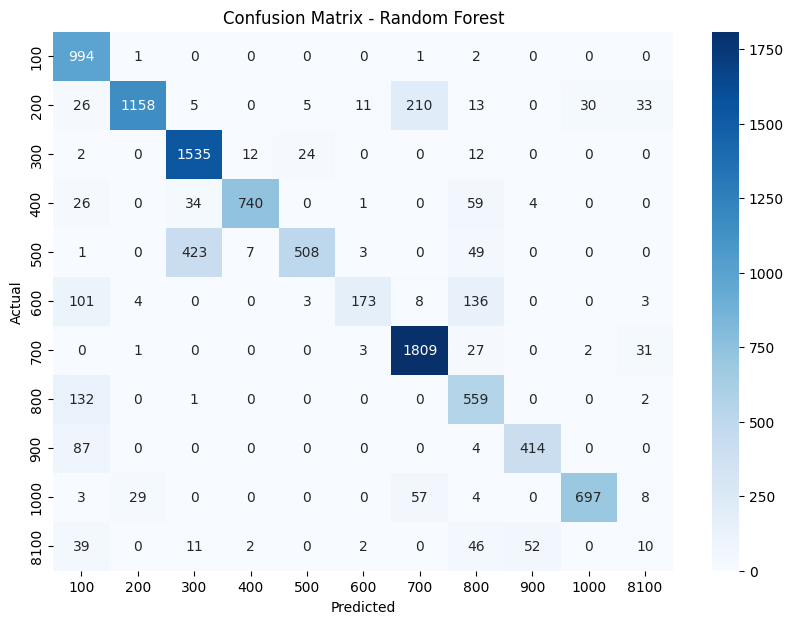


🔍 Đang huấn luyện mô hình: Logistic Regression


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

         100       0.80      0.97      0.88       998
         200       0.97      0.65      0.78      1491
         300       0.73      0.87      0.80      1585
         400       0.93      0.94      0.94       864
         500       0.71      0.40      0.51       991
         600       0.49      0.57      0.53       428
         700       0.91      0.94      0.93      1873
         800       0.74      0.97      0.84       694
         900       0.97      0.78      0.86       505
        1000       0.89      0.88      0.88       798
        8100       0.16      0.30      0.21       162

    accuracy                           0.80     10389
   macro avg       0.75      0.75      0.74     10389
weighted avg       0.82      0.80      0.80     10389



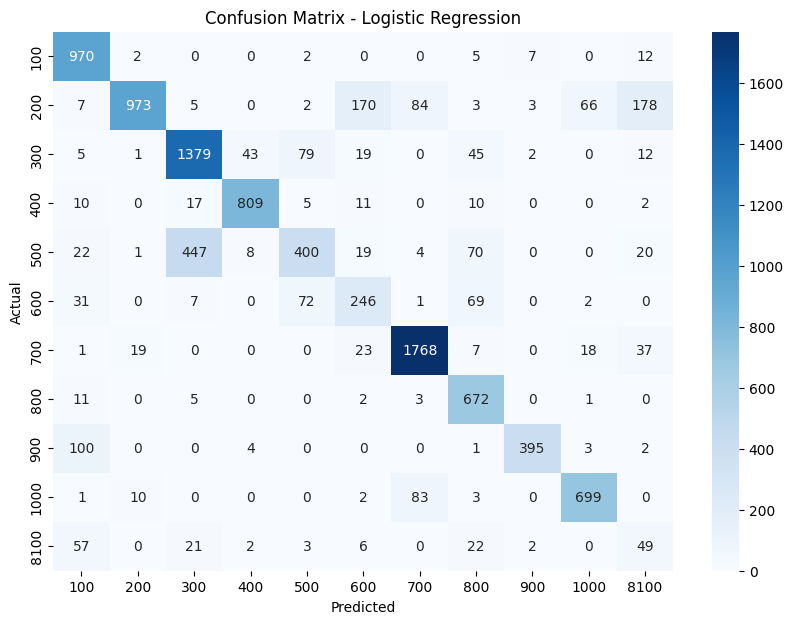


🔍 Đang huấn luyện mô hình: Extra Trees
              precision    recall  f1-score   support

         100       0.71      1.00      0.83       998
         200       0.97      0.70      0.82      1491
         300       0.75      0.96      0.85      1585
         400       0.97      0.90      0.94       864
         500       0.90      0.51      0.65       991
         600       0.87      0.34      0.48       428
         700       0.81      0.98      0.89      1873
         800       0.67      0.87      0.76       694
         900       0.88      0.74      0.80       505
        1000       0.94      0.84      0.89       798
        8100       0.15      0.03      0.05       162

    accuracy                           0.82     10389
   macro avg       0.78      0.72      0.72     10389
weighted avg       0.83      0.82      0.80     10389



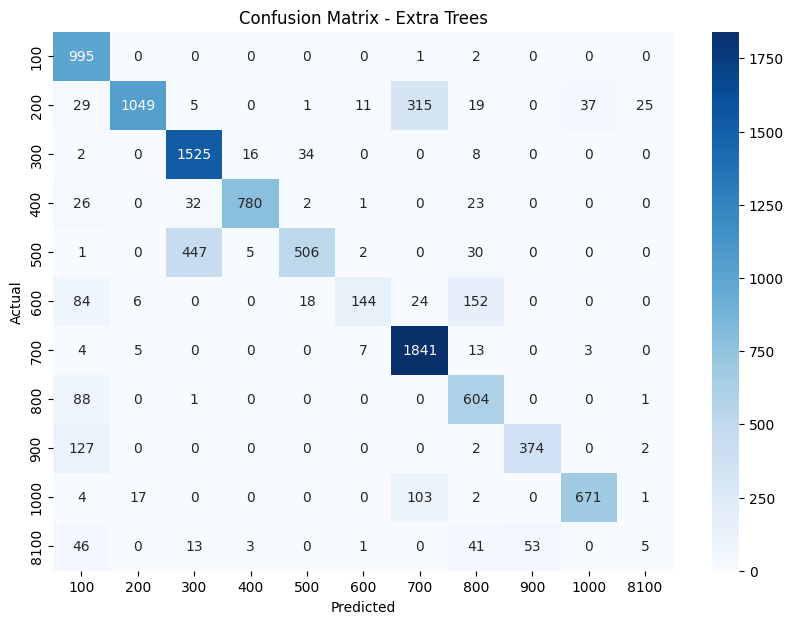


🔍 Đang huấn luyện mô hình: KNN (K-Nearest Neighbors)
              precision    recall  f1-score   support

         100       0.56      0.82      0.67       998
         200       0.66      0.38      0.48      1491
         300       0.57      0.22      0.32      1585
         400       0.83      0.75      0.79       864
         500       0.30      0.23      0.26       991
         600       0.17      0.38      0.23       428
         700       0.76      0.69      0.72      1873
         800       0.41      0.58      0.48       694
         900       0.83      0.42      0.56       505
        1000       0.54      0.76      0.63       798
        8100       0.03      0.15      0.05       162

    accuracy                           0.51     10389
   macro avg       0.52      0.49      0.47     10389
weighted avg       0.59      0.51      0.52     10389



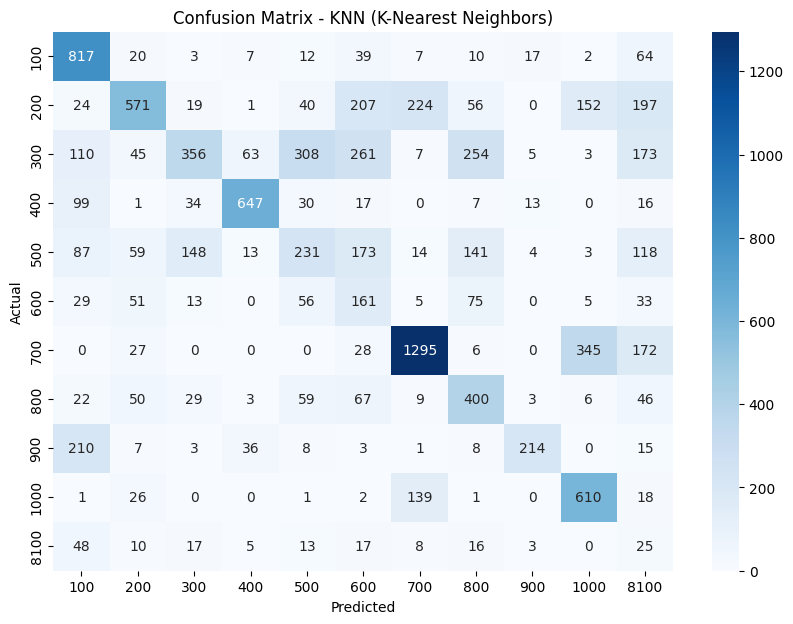


🔍 Đang huấn luyện mô hình: XGBoost
              precision    recall  f1-score   support

         100       0.75      1.00      0.86       998
         200       0.99      0.67      0.80      1491
         300       0.74      0.96      0.83      1585
         400       0.95      0.95      0.95       864
         500       0.85      0.46      0.60       991
         600       1.00      0.25      0.41       428
         700       0.87      0.94      0.90      1873
         800       0.61      0.82      0.70       694
         900       0.91      0.90      0.91       505
        1000       0.83      0.93      0.88       798
        8100       0.15      0.10      0.12       162

    accuracy                           0.81     10389
   macro avg       0.79      0.73      0.72     10389
weighted avg       0.84      0.81      0.80     10389



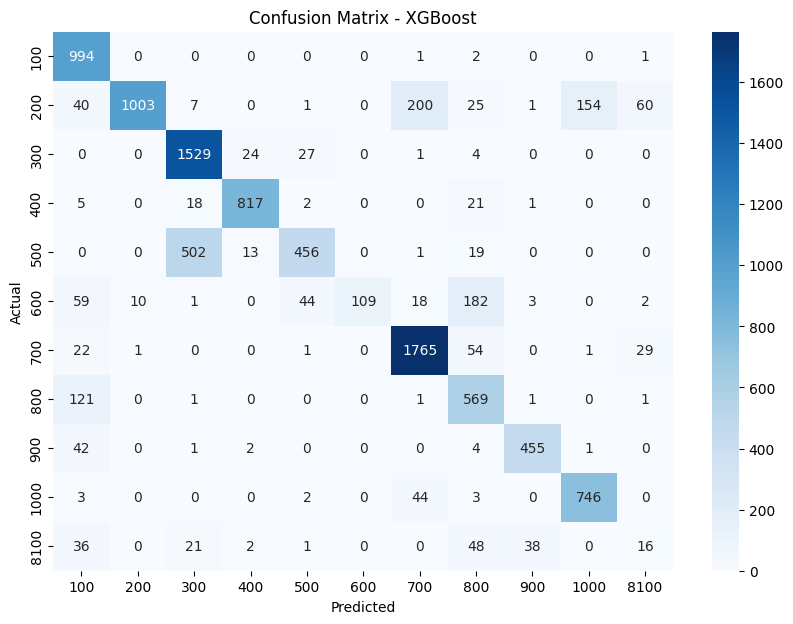


🔍 Đang huấn luyện mô hình: LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.237290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39114
[LightGBM] [Info] Number of data points in the train set: 93687, number of used features: 179
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

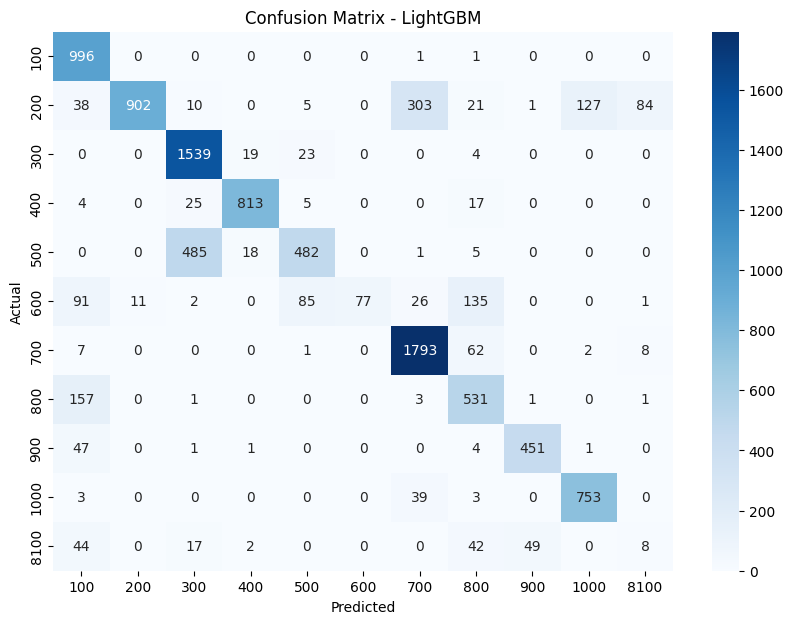

In [63]:
# Các model sẽ thử nghiệm
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Extra Trees": ExtraTreesClassifier(random_state=42),
    "KNN (K-Nearest Neighbors)": KNeighborsClassifier(n_neighbors=7),
    "XGBoost": XGBClassifier(random_state=42),
    "LightGBM": LGBMClassifier
     (
        n_estimators=200,
        learning_rate=0.1
      )
}

# Huấn luyện và đánh giá từng model
for model_name, model in models.items():
    print(f"\n🔍 Đang huấn luyện mô hình: {model_name}")
    model.fit(X_train_resampled, y_train_resampled)

    y_pred_encoded = model.predict(X_test)

    y_pred = label_encoder.inverse_transform(y_pred_encoded)
    y_test_original = label_encoder.inverse_transform(y_test_encoded)

    print(classification_report(y_test_original, y_pred))

    plt.figure(figsize=(10, 7))
    sns.heatmap(confusion_matrix(y_test_original, y_pred), annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()